In [68]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf

  Activating environment at `C:\Users\hilld\Documents\git\ocrl\HW4_S24\Project.toml`


## Dynamics

In [194]:
function skew_symmetric(r::Vector) #function to convert vector to cross-product skew-symmetric matrix
    R = [0 -r[3] r[2]; r[3] 0 -r[1]; -r[2] r[1] 0]
    return R
end

#dynamics function of quadruped
function dynamics(model::NamedTuple, x::Vector, u::Vector, r1::Vector, r2::Vector, r3::Vector, r4::Vector)
    #state is defined as [x,theta,x_dot,theta_dot]^T
    #force is defined as [fl,fr,bl,br]^T where each one is composed of x,y,z forces
    
    m, J, g = model.m, model.J, model.g

    A = vcat(hcat(zeros(6,6), Matrix{Float64}(I,6,6)), zeros(6,12)) #A matrix
    #B1 is first 9 rows of B matrix, first 6 rows are zeros, next rows are F = ma
    B1 = vcat(zeros(6,12), 1/m * hcat(hcat(Matrix{Float64}(I,3,3),Matrix{Float64}(I,3,3)),hcat(Matrix{Float64}(I,3,3),Matrix{Float64}(I,3,3))))
    #B2 is last 3 rows of B matrix effecting theta_dot, these are tau = J*theta_dot
    J_inv = inv(J)
    B2 = hcat(hcat(J_inv * skew_symmetric(r1 - x[1:3]), J_inv * skew_symmetric(r2 - x[1:3])),hcat(J_inv * skew_symmetric(r3 - x[1:3]), J_inv * skew_symmetric(r4 - x[1:3])))
    B = vcat(B1,B2) #add B1 to B2 to get full B matrix
    
    C = vcat(vcat(zeros(8),-g),zeros(3)) #gravity term (not sure if this is done right)
    
    x_dot = A * x + B * u + C #calculate x_dot (full state derivative)
    
    return x_dot
end

#rk4 function for discritization of dynamics
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, r1::Vector, r2::Vector, r3::Vector, r4::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u, r1, r2, r3, r4)
    k2 = dt * ode(model, x + k1/2, u, r1, r2, r3, r4)
    k3 = dt * ode(model, x + k2/2, u, r1, r2, r3, r4)
    k4 = dt * ode(model, x + k3,   u, r1, r2, r3, r4)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end  


rk4 (generic function with 1 method)

## Reference Trajectory and Gait Planner

In [257]:
function reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)
    # creates a reference Xref and Uref for walker
    
    l, w, m, g = model.l, model.w, model.m, model.g
    
    N = Int(num_gaits * gait_period / dt) #define N
    
    @show half_gait = Int(gait_period / (2 * dt))     #number of time steps in half a gait period
    @show quarter_gait = Int(gait_period / (4 * dt))  #number of time steps in a quarter of a gait period
    
    fl_s = zeros(N) #initialize fl_s etc. These are the gait timings
#     fl_s[1] = 1
#     fl_s[N] = 1
    fr_s = zeros(N)
#     fr_s[1] = 1
#     fr_s[N] = 1
    bl_s = zeros(N)
#     bl_s[1] = 1    
#     bl_s[N] = 1
    br_s = zeros(N)
#     br_s[1] = 1
#     br_s[N] = 1
    
    fl_s[1:quarter_gait] = ones(quarter_gait)  #first quarter gait has the left feet on the ground
    bl_s[1:quarter_gait] = ones(quarter_gait)
    
    count = 1
    for i = quarter_gait+1:half_gait:N-quarter_gait  #every half gait, switch feet
        if(count % 2 == 0)
            fl_s[i:i+half_gait-1] = ones(half_gait)
            bl_s[i:i+half_gait-1] = ones(half_gait)
        else
            fr_s[i:i+half_gait-1] = ones(half_gait)
            br_s[i:i+half_gait-1] = ones(half_gait)
        end
        count = count + 1
    end
    
    fr_s[N-quarter_gait+1:N] = ones(quarter_gait) #last quater gait has the right feet on the ground
    br_s[N-quarter_gait+1:N] = ones(quarter_gait)
    
    Xref = [zeros(12) for i = 1:N] #initialize state reference trajectory
    
    v_const = (xg[1:6] - xic[1:6]) / (N * dt) #assuming straight line path, get constant velocity required
#     Xref[1] = 1*xic 
#     Xref[N] = 1*xg
    
    for i = 1:N #fill in state reference trajectory
        Xref[i] = vcat(((N-i) * xic[1:6] + i * xg[1:6]) / N, v_const)
    end
    
    Uref = [zeros(12) for i = 1:(N-1)] #initialize input reference trajectory
    
#     Uref[1] = [m/4,0,0,m/4,0,0,m/4,0,0,m/4,0,0]
    
    for i = 1:N-1 #if the foot is on the ground assume it is supporting half the weight of the robot (may need to add force to counteract tipping)
        if fl_s[i] == 1
            Uref[i][3] = g * m / 2
        end
        if fr_s[i] == 1
            Uref[i][6] = g * m / 2
        end
        if bl_s[i] == 1
            Uref[i][9] = g * m / 2
        end
        if br_s[i] == 1
            Uref[i][12] = g * m / 2
        end
    end
    
    r1 = [zeros(3) for i=1:N] #initialize r vectors
    r2 = [zeros(3) for i=1:N]
    r3 = [zeros(3) for i=1:N]
    r4 = [zeros(3) for i=1:N]
    
    r1[1:quarter_gait] = [[l/2, w/2, -Xref[1][3]] + Xref[1][1:3] for j=1:quarter_gait] #for first quarter gait, set legs directly below shoulders to start
    r2[1:quarter_gait] = [[l/2, -w/2, -Xref[1][3]] + Xref[1][1:3] for j=1:quarter_gait]
    r3[1:quarter_gait] = [[-l/2, w/2, -Xref[1][3]] + Xref[1][1:3] for j=1:quarter_gait]
    r4[1:quarter_gait] = [[-l/2, -w/2, -Xref[1][3]] + Xref[1][1:3] for j=1:quarter_gait]
    
    for i = quarter_gait+1:half_gait:N-quarter_gait #for each sequential half gait, set legs reaching past shoulders to start
        r1[i:i+half_gait-1] = [[l/2, w/2, -Xref[i][3]] + Xref[i][1:3] + gait_period / 4 * v_const[1:3] for j=1:half_gait]
        r2[i:i+half_gait-1] = [[l/2, -w/2, -Xref[i][3]] + Xref[i][1:3] + gait_period / 4 * v_const[1:3] for j=1:half_gait]
        r3[i:i+half_gait-1] = [[-l/2, w/2, -Xref[i][3]] + Xref[i][1:3] + gait_period / 4 * v_const[1:3] for j=1:half_gait]
        r4[i:i+half_gait-1] = [[-l/2, -w/2, -Xref[i][3]] + Xref[i][1:3] + gait_period / 4 * v_const[1:3] for j=1:half_gait]
    end
    
    r1[N-quarter_gait+1:N] = [[l/2, w/2, -Xref[N][3]] + Xref[N][1:3] for j=1:quarter_gait] #for last quarter gait, set legs directly below shoulders to end
    r2[N-quarter_gait+1:N] = [[l/2, -w/2, -Xref[N][3]] + Xref[N][1:3] for j=1:quarter_gait]
    r3[N-quarter_gait+1:N] = [[-l/2, w/2, -Xref[N][3]] + Xref[N][1:3] for j=1:quarter_gait]
    r4[N-quarter_gait+1:N] = [[-l/2, -w/2, -Xref[N][3]] + Xref[N][1:3] for j=1:quarter_gait]
        
    return Xref, Uref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4
end

reference_trajectory (generic function with 2 methods)

## Solve

half_gait = Int(gait_period / (2dt)) = 20
quarter_gait = Int(gait_period / (4dt)) = 10

ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+000  -2.150e+002  +1e+005  7e-001  1e+000  1e+000  7e+001    ---    ---    2  2  - |  -  - 
 1  +3.651e+003  +3.458e+003  +1e+005  6e-001  2e-002  4e+001  5e+001  0.6367  5e-001   3  2  1 |  0  0
 2  +2.713e+003  +2.644e+003  +5e+004  3e-001  5e-003  3e+001  2e+001  0.5351  7e-002   2  1  1 |  0  0
 3  +3.088e+003  +3.039e+003  +3e+004  5e-001  4e-003  6e+001  2e+001  0.7496  5e-001   1  1  1 |  0  0
 4  +4.338e+003  +4.327e+003  +1e+004  5e-001  3e-003  6e+001  7e+000  0.7409  3e-001   2  1  1 |  0  0
 5  +5.433e+003  +5.442e+003  +8e+003  5e-001  2e-003  7e+001  4e+000  0.8038  5e-001   2  1  1 |  0  0
 6  +1.018e+004  +1.022e+004  +4e+003  4e-001  2e-003  1e+002  2e+000  0.6006  2e-001   2  1  1 |  0  0


┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\hilld\.julia\packages\Convex\b2S4H\src\solution.jl:342


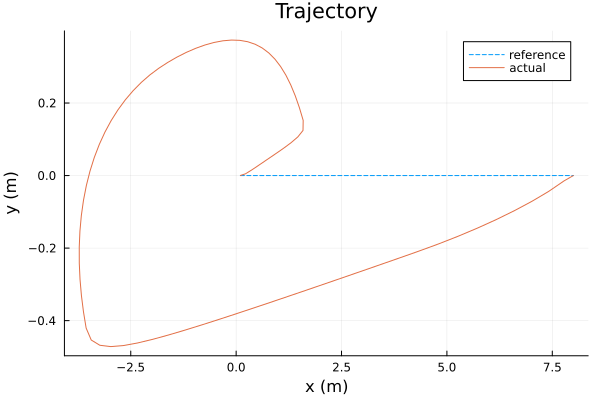

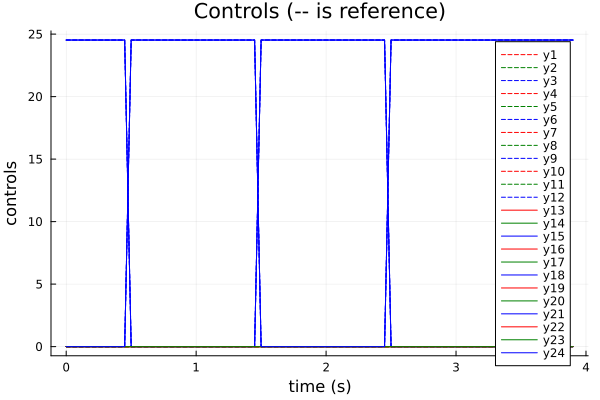

In [259]:
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

#model defined here
model = (g = 9.81, m = 5.0, J = diagm([1,5.2,5.8]), l = 1.0, w = 0.4, h = 0.6, mu = 0.6)
v = 2
dt = 0.05
gait_period = 2
num_gaits = 2
xic = [0,0,model.h,0,0,0,0,0,0,0,0,0]
xg = [v * gait_period * num_gaits,0,model.h,0,0,0,0,0,0,0,0,0]

#construct reference trajectory
Xref, Uref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4 = reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)

# @show r1
# @show r2
# @show r3
# @show r4

tf = N * dt 
t_vec = 0:dt:tf 

nx = 12
nu = 12

# LQR tracking cost to be used in ILC 
Q = diagm([1,1,1,0.1,0.1,0.1,1,1,1,0.01,0.01,0.01])
R = 0.1*diagm(ones(nu))
Qf = 10*diagm([1,1,1,0.1,0.1,0.1,1,1,1,0.01,0.01,0.01])
            
# calculate Jacobians
As = [zeros(nx,nx) for i = 1:N-1]
Bs = [zeros(nx,nu) for i = 1:N-1]
for i = 1:N-1
    As[i] = FD.jacobian(x -> rk4(model, dynamics, x, Uref[i], r1[i], r2[i], r3[i], r4[i], dt), Xref[i])
    Bs[i] = FD.jacobian(u -> rk4(model, dynamics, Xref[i], u, r1[i], r2[i], r3[i], r4[i], dt), Uref[i])
end
#this C is our gravity term (not sure if this is done correctly)
C = rk4(model, dynamics, zeros(12), zeros(12), r1[1], r2[1], r3[1], r4[1], dt)

# create variables 
X = cvx.Variable(nx, N)
U = cvx.Variable(nu, N-1)

# cost function (tracking cost on Xref, Uref)
cost = 0.0
for k = 1:(N-1)
    # add stagewise cost 
    cost += 0.5*cvx.quadform(X[:,k] - Xref[k],Q) + 0.5*cvx.quadform(U[:,k] - Uref[k],R)
end

# add terminal cost 
cost += 0.5*cvx.quadform(X[:,N] - Xref[N],Qf)

# problem instance
prob = cvx.minimize(cost)

# initial condition constraint
prob.constraints += (X[:,1] == Xref[1])

# final condition constraint
prob.constraints += (X[:,N] == Xref[N])

# dynamics constraints
for k = 1:(N-1)
    prob.constraints += (X[:,k+1] == As[k]*X[:,k] + Bs[k]*U[:,k] + C)
end

#height constraint (no limbo)
for k = 1:N
    prob.constraints += (X[3,k] > model.h * 0.9)
    prob.constraints += (X[3,k] < model.h * 1.1)
end

#gait constraints (only able to use feet when the are on the ground)
for k = 1:N-1
    if fl_s[k] == 0
        prob.constraints += (U[3,k] == 0)
    else
        prob.constraints += (U[3,k] >= 0)        
    end
    if fr_s[k] == 0
        prob.constraints += (U[6,k] == 0)
    else
        prob.constraints += (U[6,k] >= 0)  
    end
    if bl_s[k] == 0
        prob.constraints += (U[9,k] == 0)
    else
        prob.constraints += (U[9,k] >= 0)  
    end
    if br_s[k] == 0
        prob.constraints += (U[12,k] == 0)
    else
        prob.constraints += (U[12,k] >= 0)  
    end
end

#friction constraints (friction cone)
for k = 1:N-1
    #front left
    prob.constraints += (U[1,k] < model.mu * U[3,k])
    prob.constraints += (U[1,k] > -model.mu * U[3,k])
    prob.constraints += (U[2,k] < model.mu * U[3,k])
    prob.constraints += (U[2,k] > -model.mu * U[3,k])
    #front right
    prob.constraints += (U[4,k] < model.mu * U[6,k])
    prob.constraints += (U[4,k] > -model.mu * U[6,k])
    prob.constraints += (U[5,k] < model.mu * U[6,k])
    prob.constraints += (U[5,k] > -model.mu * U[6,k])
    #back left
    prob.constraints += (U[7,k] < model.mu * U[9,k])
    prob.constraints += (U[7,k] > -model.mu * U[9,k])
    prob.constraints += (U[8,k] < model.mu * U[9,k])
    prob.constraints += (U[8,k] > -model.mu * U[9,k])
    #back right
    prob.constraints += (U[10,k] < model.mu * U[12,k])
    prob.constraints += (U[10,k] > -model.mu * U[12,k])
    prob.constraints += (U[11,k] < model.mu * U[12,k])
    prob.constraints += (U[11,k] > -model.mu * U[12,k])
end

cvx.solve!(prob, ECOS.Optimizer; silent_solver = false) #solver does the heavy lifting

# get X and U
X = vec_from_mat(X.value)
U = vec_from_mat(U.value)

#simulate to see if our dynamics are right
# X = [zeros(12) for i = 1:N]
# X[1] = Xref[1]

# for i = 1:N-1
#     X[i+1] = rk4(model, dynamics, X[i], Uref[i], r1[i], r2[i], r3[i], r4[i], dt)
# end

#plots
Xm= hcat(X...)
Um = hcat(Uref...)
Xrefm = hcat(Xref...)
Urefm = hcat(Uref...)

# @show (hcat(r3...) - Xrefm[1:3,:])[1:3,:]

plot(Xrefm[1,:], Xrefm[2,:], ls = :dash, label = "reference",
xlabel = "x (m)", ylabel = "y (m)", title = "Trajectory")
display(plot!(Xm[1,:], Xm[2,:], label = "actual"))
    
plot(t_vec[1:end-2], Urefm[1:12,:]', ls = :dash, lc = [:red :green :blue :red :green :blue :red :green :blue :red :green :blue],
xlabel = "time (s)", ylabel = "controls", title = "Controls (-- is reference)")
display(plot!(t_vec[1:end-2], Um[1:12,:]', lc = [:red :green :blue :red :green :blue :red :green :blue :red :green :blue]))